<center>

# Football Analytics - Player Shots in Competition

Neste notebook iremos explorar chutes de um jogador selecionado em uma competição inteira selecionada.  

## IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from urllib.request import urlopen
from mplsoccer import Sbopen, Pitch, FontManager, VerticalPitch, add_image
from PIL import Image
from statsbombpy import sb

In [2]:
# Ajustar as configurações de exibição
pd.set_option('display.max_columns', None)  # None permite mostrar todas as colunas

## EXTRAINDO AS COMPETIÇÕES E TEMPORADAS DISPONÍVEIS

In [3]:
competitions = sb.competitions()
competitions.head(3)

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-06-13T07:51:02.452825,None,None,2024-06-13T07:51:02.452825


In [4]:
# Criando uma lista com todas competições e seus respectivos ids, ordenadas de forma alfabética
competitions_list = competitions[['competition_name', 'competition_id']].drop_duplicates().reset_index(drop=True)

competitions_list

,competition_name,competition_id
0,1. Bundesliga,9
1,African Cup of Nations,1267
2,Champions League,16
3,Copa America,223
4,Copa del Rey,87
5,FA Women's Super League,37
6,FIFA U20 World Cup,1470
7,FIFA World Cup,43
8,Indian Super league,1238
9,La Liga,11


In [5]:
# Criando uma lista com todas as temporadas listadas da mais recente para a mais antiga
seasons_list = competitions[['season_name', 'season_id']].sort_values(by='season_name', ascending=False).drop_duplicates().reset_index(drop=True)

seasons_list

,season_name,season_id
0,2024,282
1,2023/2024,281
2,2023,107
3,2022/2023,235
4,2022,106
5,2021/2022,108
6,2020/2021,90
7,2020,43
8,2019/2020,42
9,2019,30


## SELECIONANDO COMPETIÇÃO E TEMPORADA

In [6]:
# Altere o id da competição e da temporada conforme desejar observando as listagens acima
campeonato = sb.matches(competition_id=43, season_id=106)
campeonato.head(3)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3857256,2022-12-02,21:00:00.000,International - FIFA World Cup,2022,Serbia,Switzerland,2,3,available,available,2023-02-17T23:45:15.306706,2023-04-26T23:49:58.956186,3,Group Stage,Stadium 974,Fernando Andrés Rapallini,Dragan Stojković,Murat Yakin,1.1.0,2,2
1,3869151,2022-12-03,21:00:00.000,International - FIFA World Cup,2022,Argentina,Australia,2,1,available,available,2023-07-30T07:46:05.382784,2023-07-30T07:48:51.865595,4,Round of 16,Ahmad bin Ali Stadium,Szymon Marciniak,Lionel Sebastián Scaloni,Graham James Arnold,1.1.0,2,2
2,3857257,2022-11-30,17:00:00.000,International - FIFA World Cup,2022,Australia,Denmark,1,0,available,available,2023-04-28T17:13:10.958725,2023-06-20T11:04:37.638969,3,Group Stage,Al Janoub Stadium,Mustapha Ghorbal,Graham James Arnold,Kasper Hjulmand,1.1.0,2,2


In [7]:
# Checando a escrita exata de cada equipe
campeonato['home_team'].sort_values().unique()

array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Cameroon',
       'Canada', 'Costa Rica', 'Croatia', 'Denmark', 'Ecuador', 'England',
       'France', 'Germany', 'Ghana', 'Iran', 'Japan', 'Mexico', 'Morocco',
       'Netherlands', 'Poland', 'Portugal', 'Qatar', 'Saudi Arabia',
       'Senegal', 'Serbia', 'South Korea', 'Spain', 'Switzerland',
       'Tunisia', 'United States', 'Uruguay', 'Wales'], dtype=object)

## SELECIONANDO EQUIPE 

In [8]:
# Filtrando partidas de uma seleção específica (Selecione a equipe que desejar e substitua na variável 'equipe')
equipe = 'Brazil'
df_partidas = campeonato.loc[(campeonato['home_team'] == f'{equipe}')|(campeonato['away_team'] == f'{equipe}')]
df_partidas.head(3)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
3,3857258,2022-11-24,21:00:00.000,International - FIFA World Cup,2022,Brazil,Serbia,2,0,available,available,2023-06-24T17:17:27.911026,2023-07-11T14:56:31.096588,1,Group Stage,Lusail Stadium,Alireza Faghani,Telê Santana da Silva,Dragan Stojković,1.1.0,2,2
14,3857269,2022-11-28,18:00:00.000,International - FIFA World Cup,2022,Brazil,Switzerland,1,0,available,available,2023-03-28T12:54:30.503171,2023-07-11T15:07:29.255525,2,Group Stage,Stadium 974,Ivan Arcides Barton Cisneros,Adenor Leonardo Bacchi,Murat Yakin,1.1.0,2,2
22,3869420,2022-12-09,17:00:00.000,International - FIFA World Cup,2022,Croatia,Brazil,1,1,available,available,2023-04-19T06:28:33.041249,2023-04-26T23:04:13.569501,5,Quarter-finals,Education City Stadium,Michael Oliver,Zlatko Dalić,Telê Santana da Silva,1.1.0,2,2


In [9]:
# Extarindo a lista de jogos da equipe selecionada
jogos_ids = df_partidas['match_id'].unique().tolist()
jogos_ids

[3857258, 3857269, 3869420, 3869253, 3857280]

In [10]:
# Inicializar o parser
parser = Sbopen()

# Listas para armazenar os dataframes
all_df = []
all_related = []
all_freeze = []
all_tactics = []

# Iterar sobre cada ID de jogo e coletar os dados
for jogo in jogos_ids:
    df, related, freeze, tactics = parser.event(jogo)
    
    # Adicionar os dataframes coletados às listas correspondentes
    all_df.append(df)
    all_related.append(related)
    all_freeze.append(freeze)
    all_tactics.append(tactics)

df_combined = pd.concat(all_df, ignore_index=True) # Informações de eventos detalhados
related_combined = pd.concat(all_related, ignore_index=True) # Informação de eventos relacionados (ex: Pass - Ball Receipt)
freeze_combined = pd.concat(all_freeze, ignore_index=True) # Informações de coordenada dos eventos
tactics_combined = pd.concat(all_tactics, ignore_index=True) # informações dos jogadores(nº camisa, posição, nome e ID)

In [11]:
# df contendo todos os jogos da equipe selecionada
df_combined.sample(3)

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,end_x,end_y,body_part_id,body_part_name,sub_type_id,sub_type_name,x,y,under_pressure,counterpress,outcome_id,outcome_name,out,pass_cross,pass_switch,off_camera,foul_committed_card_id,foul_committed_card_name,aerial_won,foul_committed_advantage,foul_won_advantage,foul_won_defensive,technique_id,technique_name,shot_one_on_one,shot_statsbomb_xg,end_z,goalkeeper_position_id,goalkeeper_position_name,injury_stoppage_in_chain,pass_assisted_shot_id,pass_shot_assist,shot_key_pass_id,dribble_nutmeg,ball_recovery_recovery_failure,dribble_overrun,ball_recovery_offensive,shot_first_time,block_offensive,substitution_replacement_id,substitution_replacement_name,bad_behaviour_card_id,bad_behaviour_card_name,pass_goal_assist,pass_cut_back,block_deflection,shot_deflected,dribble_no_touch,foul_committed_offensive,pass_miscommunication,pass_deflected,pass_no_touch,half_start_late_video_start,foul_committed_penalty,foul_won_penalty
7262,2a10cbc7-c6a0-4780-ac50-9415cff9fe6d,3607,2,00:46:43.829000,91,43,162,1.682153,3857269,30,Pass,773,Switzerland,3,From Free Kick,773,Switzerland,None,8814.0,Nico Elvedi,5.0,Left Center Back,5549.0,Manuel Obafemi Akanji,19.969978,1.440230,1.0,Ground Pass,53.0,44.3,38.0,Left Foot,NaN,NaN,50.4,24.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2849,2b11ee07-1821-4135-9c6a-9130f6b23f8c,2850,2,00:31:13.909000,76,13,137,1.913244,3857258,30,Pass,781,Brazil,1,Regular Play,781,Brazil,None,3280.0,Richarlison de Andrade,23.0,Center Forward,3063.0,Danilo Luiz da Silva,19.027610,1.154173,1.0,Ground Pass,87.1,76.6,40.0,Right Foot,NaN,NaN,79.4,59.2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13435,8b6792a4-3c4c-4313-b62d-742d1fa1e94a,848,1,00:22:18.626000,22,18,30,0.881992,3869253,43,Carry,791,South Korea,4,From Throw In,791,South Korea,None,5618.0,Woo-Young Jung,9.0,Right Defensive Midfield,NaN,NaN,NaN,NaN,NaN,NaN,89.5,32.3,NaN,NaN,NaN,NaN,88.6,32.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Extraindo os nomes das ações que podem ser analisadas
df_combined['type_name'].sort_values().unique()

array(['50/50', 'Bad Behaviour', 'Ball Receipt', 'Ball Recovery', 'Block',
       'Carry', 'Clearance', 'Dispossessed', 'Dribble', 'Dribbled Past',
       'Duel', 'Error', 'Foul Committed', 'Foul Won', 'Goal Keeper',
       'Half End', 'Half Start', 'Injury Stoppage', 'Interception',
       'Miscontrol', 'Offside', 'Pass', 'Player Off', 'Player On',
       'Pressure', 'Referee Ball-Drop', 'Shield', 'Shot', 'Starting XI',
       'Substitution', 'Tactical Shift'], dtype=object)

In [23]:
df_shot = df_combined[df_combined['type_name'] == 'Shot']
df_shot = df_shot[df_shot['team_name'] == equipe]

df_shot.head(3)

,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,end_x,end_y,body_part_id,body_part_name,sub_type_id,sub_type_name,x,y,under_pressure,counterpress,outcome_id,outcome_name,out,pass_cross,pass_switch,off_camera,foul_committed_card_id,foul_committed_card_name,aerial_won,foul_committed_advantage,foul_won_advantage,foul_won_defensive,technique_id,technique_name,shot_one_on_one,shot_statsbomb_xg,end_z,goalkeeper_position_id,goalkeeper_position_name,injury_stoppage_in_chain,pass_assisted_shot_id,pass_shot_assist,shot_key_pass_id,dribble_nutmeg,ball_recovery_recovery_failure,dribble_overrun,ball_recovery_offensive,shot_first_time,block_offensive,substitution_replacement_id,substitution_replacement_name,bad_behaviour_card_id,bad_behaviour_card_name,pass_goal_assist,pass_cut_back,block_deflection,shot_deflected,dribble_no_touch,foul_committed_offensive,pass_miscommunication,pass_deflected,pass_no_touch,half_start_late_video_start,foul_committed_penalty,foul_won_penalty
534,7e920dff-ac95-416c-afd5-aa517b812da3,535,1,00:12:53.811000,12,53,30,1.332265,3857258,16,Shot,781,Brazil,2,From Corner,781,Brazil,None,4320.0,Neymar da Silva Santos Junior,19.0,Center Attacking Midfield,NaN,NaN,NaN,NaN,NaN,NaN,119.7,38.7,40.0,Right Foot,61.0,Corner,119.2,0.7,NaN,NaN,100.0,Saved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.0,Normal,True,0.000180,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
849,f3f39fb8-e43b-4b26-a093-c2c6a32d41f9,850,1,00:20:06.595000,20,6,45,0.495812,3857258,16,Shot,781,Brazil,1,Regular Play,781,Brazil,None,4320.0,Neymar da Silva Santos Junior,19.0,Center Attacking Midfield,NaN,NaN,NaN,NaN,NaN,NaN,104.9,34.5,40.0,Right Foot,87.0,Open Play,91.6,29.2,NaN,NaN,96.0,Blocked,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.0,Normal,NaN,0.020174,NaN,NaN,NaN,NaN,NaN,NaN,1f9c127f-80b0-4fea-b085-0eefd0e1474c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
899,35280e71-5804-4d3c-9d47-b7343809003f,900,1,00:20:51.885000,20,51,45,1.134041,3857258,16,Shot,781,Brazil,1,Regular Play,781,Brazil,None,5539.0,Carlos Henrique Casimiro,11.0,Left Defensive Midfield,NaN,NaN,NaN,NaN,NaN,NaN,117.8,39.9,40.0,Right Foot,87.0,Open Play,84.3,34.2,NaN,NaN,100.0,Saved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.0,Normal,NaN,0.007537,1.7,NaN,NaN,NaN,NaN,NaN,611f58e7-0beb-4e8b-810f-4a574b7d6abb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


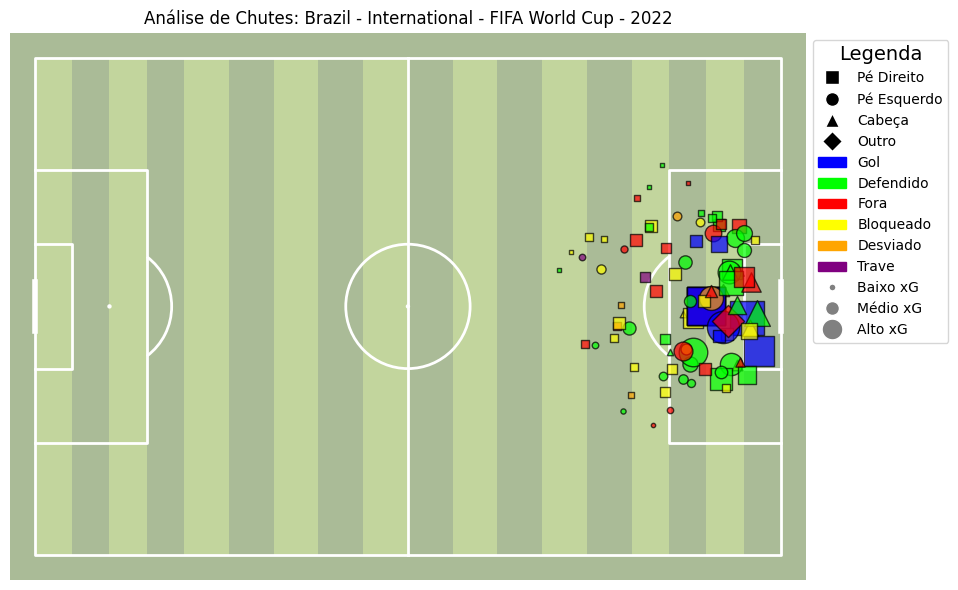

In [24]:
df_filtered = df_shot[df_shot.team_name == equipe].reset_index(drop=True)

start_x = df_filtered.x
start_y = df_filtered.y
body_part_name = df_filtered.body_part_name
outcome_name = df_filtered.outcome_name
xg = df_filtered.shot_statsbomb_xg

# Formas geométricas para a parte do corpo
markers = []
for part in body_part_name:
    if part == 'Right Foot':
        markers.append('s')  # Quadrado
    elif part == 'Left Foot':
        markers.append('o')  # Círculo
    elif part == 'Head':
        markers.append('^')  # Triângulo
    else:
        markers.append('D')  # Losango para 'Other'

# Cores para o outcome
color_map = {
    'Goal': '#0000FF',  # Azul para gol
    'Saved': '#00FF00',  # Verde para defesa
    'Off T': '#FF0000',  # Vermelho para fora
    'Blocked': '#FFFF00',  # Amarelo para bloqueado
    'Wayward': '#FFA500',  # Laranja para Wayward (desviado)
    'Post': '#800080'}  # Roxo para na trave
colors = [color_map[outcome] for outcome in outcome_name]

# Tamanho com base no xG
sizes = xg * 1000 

# Campo
pitch = Pitch(pitch_color='#aabb97', line_color='white', stripe_color='#c2d59d', stripe=True)
fig, ax = pitch.draw(figsize=(10, 6))

# Plotando os chutes
for i in range(len(df_filtered)):
    pitch.scatter(start_x[i], start_y[i], s=sizes[i], ax=ax, color=colors[i], marker=markers[i], edgecolor='black', alpha=0.7)

# legenda das partes do corpo usadas
legend_shapes = [
    Line2D([0], [0], marker='s', color='w', label='Pé Direito', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Pé Esquerdo', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='^', color='w', label='Cabeça', markerfacecolor='black', markersize=10),
    Line2D([0], [0], marker='D', color='w', label='Outro', markerfacecolor='black', markersize=10)]

# legenda de resultados do chute (outcome)
legend_colors = [
    mpatches.Patch(color='#0000FF', label='Gol'),
    mpatches.Patch(color='#00FF00', label='Defendido'),
    mpatches.Patch(color='#FF0000', label='Fora'),
    mpatches.Patch(color='#FFFF00', label='Bloqueado'),
    mpatches.Patch(color='#FFA500', label='Desviado'),
    mpatches.Patch(color='#800080', label='Trave')]
    
# legenda para o xG (escala de tamanho)
legend_sizes = [
    Line2D([0], [0], marker='o', color='w', label='Baixo xG', markerfacecolor='gray', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Médio xG', markerfacecolor='gray', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Alto xG', markerfacecolor='gray', markersize=15)]

plt.legend(
    handles=legend_shapes + legend_colors + legend_sizes,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    title= "Legenda",
    title_fontsize=14,
    fontsize=10)

plt.title(f'Análise de Chutes: {equipe} - {campeonato['competition'].loc[0]} - {campeonato['season'].loc[0]}')
plt.show()
